In [1]:
import tensorflow as tf
import keras
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
!pip install kaggle

In [3]:
# Add this to external cookies allowed list   -  [*.]googleusercontent.com:443
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"shivtejshete","key":"d8a54598045a41f573268a96a799fc38"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d manjeetsingh/retaildataset

  0% 0.00/3.11M [00:00<?, ?B/s]
100% 3.11M/3.11M [00:00<00:00, 105MB/s]


In [6]:
!ls

kaggle.json  retaildataset.zip	sample_data


In [7]:
import zipfile
zip_ref = zipfile.ZipFile('retaildataset.zip' , 'r')
zip_ref.extractall('retail')
zip_ref.close()

In [8]:
os.listdir('/content/retail')

['Features data set.csv', 'stores data-set.csv', 'sales data-set.csv']

In [9]:
import os
root = os.getcwd()

_feature=root+'/retail/Features data set.csv'
_store=root+'/retail/stores data-set.csv'
_sales=root+'/retail/sales data-set.csv'

In [10]:
import pandas as pd
features = pd.read_csv(_feature)
sales = pd.read_csv(_sales)
stores = pd.read_csv(_store)

In [12]:
#aggregate sales to weekly level inter-store
sales_agg = sales.pivot_table(index=['Store','Date','IsHoliday'], values=['Weekly_Sales'],aggfunc=np.sum).reset_index()

In [13]:
#left join features with sales
merged = pd.merge(features, sales_agg, how='left', on= ['Store', 'Date'], )

In [14]:
merged=merged.loc[:,['Store',
 'Date',
 'Temperature',
 'Fuel_Price',
 'MarkDown1',
 'MarkDown2',
 'MarkDown3',
 'MarkDown4',
 'MarkDown5',
 'CPI',
 'Unemployment',
 'IsHoliday_x',
 'Weekly_Sales']].merge(stores, how='left', on='Store')

merged.Date = pd.to_datetime(merged.Date)

In [15]:
merged.shape

(8190, 15)

In [16]:
merged['Month']=pd.DatetimeIndex(merged.Date).month.astype('category')

In [17]:
#Initial Record count per month
np.bincount(merged.Month)

array([  0, 630, 630, 720, 765, 810, 675, 765, 630, 630, 630, 585, 720])

In [18]:
#Records count which have nan into weekly sales, as per each month, we will remove them
np.bincount(merged.Month[merged.Weekly_Sales.isna()])

array([  0, 180, 135, 180, 135, 225, 135, 180,  90,  45,  45, 180, 225])

In [19]:
Filter1 = merged[merged.Weekly_Sales.notna()].reset_index(drop=True)

In [20]:
Filter1.isna().describe()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_x,Weekly_Sales,Type,Size,Month
count,6435,6435,6435,6435,6435,6435,6435,6435,6435,6435,6435,6435,6435,6435,6435,6435
unique,1,1,1,1,2,2,2,2,2,1,1,1,1,1,1,1
top,False,False,False,False,True,True,True,True,True,False,False,False,False,False,False,False
freq,6435,6435,6435,6435,4155,4798,4389,4470,4140,6435,6435,6435,6435,6435,6435,6435


In [ ]:
# This tells us that MarkDown1 to Markdown5 have some missing information
#There are two ways we can deal with this
# 1. We can interpolate the values of Markdown using a OLS LR method 
# 2. Assign a significantly different value to these nan in markdown to let model know that those events are different than rest of records
# We will replace the nan with -ve value (-1)

In [21]:
Filter2= Filter1.replace(np.nan,value= -1)

In [22]:
Filter2=Filter2.drop(columns=['Date'])

In [24]:
np.random.seed=11
Filter2.IsHoliday_x=pd.get_dummies(Filter2.IsHoliday_x,drop_first=True,)  #This is assigning False =0, True = 1 with this seed

In [29]:
Filter2.Store= Filter2.Store.astype('category')
Filter2.IsHoliday_x=Filter2.IsHoliday_x.astype('category')
Filter2.Type=Filter2.Type.astype('category')
Filter2.Size=Filter2.Size.astype('category')
Filter2.Month=Filter2.Month.astype('category')

In [31]:
Filter2.head()

,Store,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_x,Weekly_Sales,Type,Size,Month
0,1,42.31,2.572,-1.0,-1.0,-1.0,-1.0,-1.0,211.096358,8.106,0,1643690.90,A,151315,5
1,1,38.51,2.548,-1.0,-1.0,-1.0,-1.0,-1.0,211.242170,8.106,1,1641957.44,A,151315,12
2,1,39.93,2.514,-1.0,-1.0,-1.0,-1.0,-1.0,211.289143,8.106,0,1611968.17,A,151315,2
3,1,46.63,2.561,-1.0,-1.0,-1.0,-1.0,-1.0,211.319643,8.106,0,1409727.59,A,151315,2
4,1,46.50,2.625,-1.0,-1.0,-1.0,-1.0,-1.0,211.350143,8.106,0,1554806.68,A,151315,5


In [32]:
Filter2= pd.concat([Filter2, pd.get_dummies(Filter2.Type,drop_first=True,)], axis=1)

In [33]:
Filter2= Filter2.drop(columns=['Type'])

In [34]:
#this df we can use to feed our model
Filter2

,Store,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_x,Weekly_Sales,Size,Month,B,C
0,1,42.31,2.572,-1.00,-1.00,-1.00,-1.00,-1.00,211.096358,8.106,0,1643690.90,151315,5,0,0
1,1,38.51,2.548,-1.00,-1.00,-1.00,-1.00,-1.00,211.242170,8.106,1,1641957.44,151315,12,0,0
2,1,39.93,2.514,-1.00,-1.00,-1.00,-1.00,-1.00,211.289143,8.106,0,1611968.17,151315,2,0,0
3,1,46.63,2.561,-1.00,-1.00,-1.00,-1.00,-1.00,211.319643,8.106,0,1409727.59,151315,2,0,0
4,1,46.50,2.625,-1.00,-1.00,-1.00,-1.00,-1.00,211.350143,8.106,0,1554806.68,151315,5,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6430,45,64.88,3.997,4556.61,20.64,1.50,1601.01,3288.25,192.013558,8.684,0,713173.95,118221,9,1,0
6431,45,64.89,3.985,5046.74,-1.00,18.82,2253.43,2340.01,192.170412,8.667,0,733455.07,118221,5,1,0
6432,45,54.47,4.000,1956.28,-1.00,7.89,599.32,3990.54,192.327265,8.667,0,734464.36,118221,12,1,0
6433,45,56.47,3.969,2004.02,-1.00,3.18,437.73,1537.49,192.330854,8.667,0,718125.53,118221,10,1,0


### Training and Validation Split

In [35]:
X= Filter2.drop(columns=['Weekly_Sales'])
y= Filter2.Weekly_Sales

In [36]:
print(X.shape)
print(y.shape)

(6435, 15)
(6435,)


In [37]:
#Test Train Splitting, it splits them into almost similar distributions of data and ensures a good way to keep same population representation between train and test
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=1)

In [38]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(5148, 15)
(1287, 15)
(5148,)
(1287,)


### Modeling 

In [ ]:
#most of MarkDown variables have a log normal distribution, but for Tree algorithms we can avoid transforming those features, incase of regression or Logistic Regression, we would have thought of 
#doing the transformations to meet the assumptions of LR model

### Regression Tree

In [ ]:
#Regression Tree
from sklearn import tree
tree_model = tree.DecisionTreeRegressor(criterion='mse',random_state=111, max_features='auto', min_samples_leaf=10, )
tree_model.fit(x_train,y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=10, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=111, splitter='best')

In [ ]:
import graphviz 

dot_data = tree.export_graphviz(tree_model, out_file=None, 
                      feature_names=x_train.columns,  
                      filled=True, rounded=True,  
                      special_characters=True)  


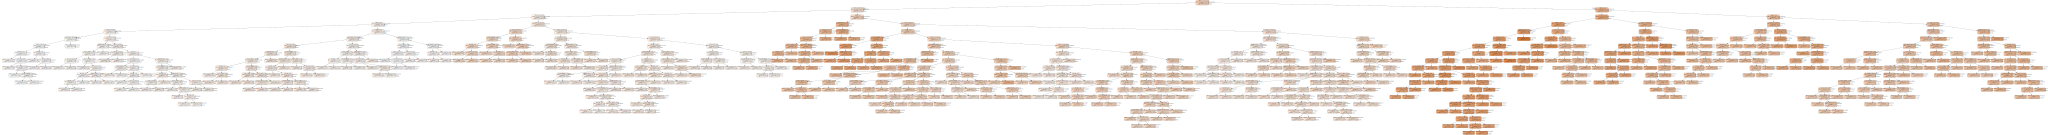

In [ ]:
graph = graphviz.Source(dot_data)  
graph 

In [ ]:
"""
 Feature Importance by Tree Algorithm :

1. This depends on how many places a feature helped in creating a pure split node
2. This also depends on probability of samples reaching that node, where the feature
splits samples into the binary groups
3. Probability = No. Sample reached to that node/ Total sample size
4. Feature importance is weighted average of both decrease in impourity of node 
with probability of samples to fall into that node

"""
for i in zip(list(tree_model.feature_importances_),x_train.columns) :
  print(i)

(0.14949676904768328, 'Store')
(0.004157262626442227, 'Temperature')
(0.006074896631377101, 'Fuel_Price')
(0.0005943230363525009, 'MarkDown1')
(0.0001757379416951457, 'MarkDown2')
(0.009718311252716112, 'MarkDown3')
(0.0008126876750661744, 'MarkDown4')
(0.00043853815879452054, 'MarkDown5')
(0.06146520654743982, 'CPI')
(0.013803903530375795, 'Unemployment')
(0.0, 'IsHoliday_x')
(0.7456121479498093, 'Size')
(0.007532991059605157, 'Month')
(0.00011722454264272684, 'B')
(0.0, 'C')


In [ ]:
#predict on test set
y_hat=tree_model.predict(x_test)
print(y_hat.shape)
print(y_test.shape)

In [ ]:
from sklearn import metrics

In [ ]:
y_test

447     1870619.23
2196     448391.99
3253    1272948.27
2873     744969.42
712      325345.41
           ...    
5523    1465283.29
2646    1440785.70
6338    1682862.03
5756    1133913.33
6239     306336.07
Name: Weekly_Sales, Length: 1287, dtype: float64

In [ ]:
y_hat

array([2086807.6       ,  475612.06      , 1220946.53363636, ...,
        849009.567     , 1135012.555625  ,  304431.589     ])

In [40]:
import numpy as np

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
mean_absolute_percentage_error(y_test, y_hat)

In [ ]:
"""Cross Validation with 10 folds on training data, this will give us more 
accurate representation of model's performance on training dataset """

from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_model, x_train, y_train, cv=10, verbose=2)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV]  ................................................................
[CV] ................................................. , total=   0.0s
[CV]  ................................................................
[CV] ................................................. , total=   0.0s
[CV]  ................................................................
[CV] ................................................. , total=   0.0s
[CV]  ................................................................
[CV] ................................................. , total=   0.0s
[CV]  ................................................................
[CV] ................................................. , total=   0.0s
[CV]  ................................................................
[CV] ................................................. , total=   0.0s
[CV]  ................................................................
[CV] ................................................. , total=   0.0s
[CV]  

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.4s finished


In [ ]:
scores

array([0.93350327, 0.91821926, 0.94059503, 0.92420064, 0.9301473 ,
       0.93467174, 0.9178942 , 0.93665359, 0.92876426, 0.92060255])

In [ ]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.93 (+/- 0.02)


# Linear Regression (Multiple Regression)

In [ ]:
x_train, x_test, y_train, y_test

In [ ]:
import statsmodels.api as sm

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
x= sm.add_constant(x_train)

In [ ]:
model = sm.OLS(y_train, x ).fit()
# predictions = model.predict(X) # make the predictions by the model

# # Print out the statistics
# model.summary()

In [ ]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Weekly_Sales   R-squared:                       0.726
Model:                            OLS   Adj. R-squared:                  0.725
Method:                 Least Squares   F-statistic:                     905.3
Date:                Tue, 10 Nov 2020   Prob (F-statistic):               0.00
Time:                        15:52:52   Log-Likelihood:                -72128.
No. Observations:                5148   AIC:                         1.443e+05
Df Residuals:                    5132   BIC:                         1.444e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         7.338e+05   5.43e+04     13.507      0.000    6.27e+05     8.4e+05
Store        -1.064e+04    385.621    -27.584      0.000   -1.14e+04   -9880.934
Temperature    407.0798    246.908      1.649      0.099     -76.966     891.125
Fuel_Price   -2.285e+04   9939.616     -2.299      0.022   -4.23e+04   -3366.261
MarkDown1        0.8581      1.401      0.612      0.540      -1.889       3.605
MarkDown2        0.1772      0.870      0.204      0.839      -1.528       1.882
MarkDown3        8.2994      0.815     10.182      0.000       6.701       9.897
MarkDown4        2.1391      1.982      1.079      0.281      -1.747       6.025
MarkDown5        5.9187      1.068      5.542      0.000       3.825       8.012
CPI          -1949.6778    118.033    -16.518      0.000   -2181.073   -1718.283
Unemployment -1.499e+04   2397.068     -6.252      0.000   -1.97e+04   -1.03e+04
IsHoliday_x   6432.1352   1.81e+04      0.355      0.723   -2.91e+04     4.2e+04
Size             7.3553      0.109     67.617      0.000       7.142       7.569
Month         8844.3909   1330.806      6.646      0.000    6235.444    1.15e+04
B            -3.763e+04   1.25e+04     -3.003      0.003   -6.22e+04   -1.31e+04
C             3.146e+05      2e+04     15.735      0.000    2.75e+05    3.54e+05
==============================================================================
Omnibus:                     1342.692   Durbin-Watson:                   2.033
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5585.793
Skew:                           1.224   Prob(JB):                         0.00
Kurtosis:                       7.478   Cond. No.                     1.94e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.94e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
predictions = model.predict(sm.add_constant(x_test))

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
mean_absolute_error(y_test, predictions)

220837.784796795

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
mean_absolute_percentage_error(y_test, predictions)

24.678340372238818

# Random Forest 

In [39]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
RF_regressor = RandomForestRegressor(n_estimators=1000, criterion='mse', max_depth=5, n_jobs=-1, random_state=111, verbose=2, )

In [ ]:
RF_regressor.fit(x_train,y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 1000
building tree 2 of 1000
building tree 3 of 1000
building tree 4 of 1000
building tree 5 of 1000
building tree 6 of 1000
building tree 7 of 1000
building tree 8 of 1000
building tree 9 of 1000
building tree 10 of 1000
building tree 11 of 1000
building tree 12 of 1000
building tree 13 of 1000
building tree 14 of 1000
building tree 15 of 1000
building tree 16 of 1000
building tree 17 of 1000
building tree 18 of 1000
building tree 19 of 1000
building tree 20 of 1000
building tree 21 of 1000
building tree 22 of 1000
building tree 23 of 1000
building tree 24 of 1000
building tree 25 of 1000
building tree 26 of 1000
building tree 27 of 1000
building tree 28 of 1000
building tree 29 of 1000
building tree 30 of 1000
building tree 31 of 1000
building tree 32 of 1000
building tree 33 of 1000
building tree 34 of 1000
building tree 35 of 1000
building tree 36 of 1000
building tree 37 of 1000
building tree 38 of 1000
building tree 39 of 1000
building tree 40 of 1000
building 

[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    0.3s


building tree 47 of 1000
building tree 48 of 1000
building tree 49 of 1000
building tree 50 of 1000
building tree 51 of 1000
building tree 52 of 1000
building tree 53 of 1000
building tree 54 of 1000
building tree 55 of 1000
building tree 56 of 1000
building tree 57 of 1000
building tree 58 of 1000
building tree 59 of 1000
building tree 60 of 1000
building tree 61 of 1000
building tree 62 of 1000
building tree 63 of 1000
building tree 64 of 1000
building tree 65 of 1000
building tree 66 of 1000
building tree 67 of 1000
building tree 68 of 1000
building tree 69 of 1000
building tree 70 of 1000
building tree 71 of 1000
building tree 72 of 1000
building tree 73 of 1000
building tree 74 of 1000
building tree 75 of 1000
building tree 76 of 1000
building tree 77 of 1000building tree 78 of 1000

building tree 79 of 1000
building tree 80 of 1000
building tree 81 of 1000
building tree 82 of 1000
building tree 83 of 1000
building tree 84 of 1000
building tree 85 of 1000
building tree 86 of 1000


[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:    1.5s


building tree 183 of 1000
building tree 184 of 1000
building tree 185 of 1000
building tree 186 of 1000
building tree 187 of 1000
building tree 188 of 1000
building tree 189 of 1000
building tree 190 of 1000
building tree 191 of 1000
building tree 192 of 1000
building tree 193 of 1000
building tree 194 of 1000
building tree 195 of 1000
building tree 196 of 1000
building tree 197 of 1000
building tree 198 of 1000
building tree 199 of 1000
building tree 200 of 1000
building tree 201 of 1000
building tree 202 of 1000
building tree 203 of 1000
building tree 204 of 1000
building tree 205 of 1000
building tree 206 of 1000
building tree 207 of 1000
building tree 208 of 1000
building tree 209 of 1000
building tree 210 of 1000
building tree 211 of 1000
building tree 212 of 1000
building tree 213 of 1000
building tree 214 of 1000
building tree 215 of 1000
building tree 216 of 1000
building tree 217 of 1000
building tree 218 of 1000
building tree 219 of 1000
building tree 220 of 1000
building tre

[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:    3.3s


building tree 367 of 1000
building tree 368 of 1000
building tree 369 of 1000
building tree 370 of 1000
building tree 371 of 1000
building tree 372 of 1000
building tree 373 of 1000
building tree 374 of 1000
building tree 375 of 1000
building tree 376 of 1000
building tree 377 of 1000
building tree 378 of 1000
building tree 379 of 1000
building tree 380 of 1000
building tree 381 of 1000
building tree 382 of 1000
building tree 383 of 1000
building tree 384 of 1000
building tree 385 of 1000
building tree 386 of 1000
building tree 387 of 1000
building tree 388 of 1000
building tree 389 of 1000
building tree 390 of 1000building tree 391 of 1000

building tree 392 of 1000
building tree 393 of 1000
building tree 394 of 1000
building tree 395 of 1000
building tree 396 of 1000
building tree 397 of 1000
building tree 398 of 1000
building tree 399 of 1000
building tree 400 of 1000
building tree 401 of 1000
building tree 402 of 1000
building tree 403 of 1000
building tree 404 of 1000
building tre

[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:    5.9s


building tree 663 of 1000
building tree 664 of 1000
building tree 665 of 1000
building tree 666 of 1000
building tree 667 of 1000
building tree 668 of 1000
building tree 669 of 1000
building tree 670 of 1000
building tree 671 of 1000
building tree 672 of 1000
building tree 673 of 1000
building tree 674 of 1000
building tree 675 of 1000
building tree 676 of 1000
building tree 677 of 1000
building tree 678 of 1000
building tree 679 of 1000
building tree 680 of 1000
building tree 681 of 1000
building tree 682 of 1000
building tree 683 of 1000
building tree 684 of 1000
building tree 685 of 1000
building tree 686 of 1000
building tree 687 of 1000
building tree 688 of 1000
building tree 689 of 1000
building tree 690 of 1000
building tree 691 of 1000
building tree 692 of 1000
building tree 693 of 1000
building tree 694 of 1000
building tree 695 of 1000
building tree 696 of 1000
building tree 697 of 1000
building tree 698 of 1000
building tree 699 of 1000
building tree 700 of 1000
building tre

[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    9.1s finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=5, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=-1, oob_score=False,
                      random_state=111, verbose=2, warm_start=False)

In [ ]:
importance = RF_regressor.feature_importances_.copy()

In [ ]:
x_train.columns.values

array(['Store', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2',
       'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment',
       'IsHoliday_x', 'Size', 'Month', 'B', 'C'], dtype=object)

In [ ]:
fi= []
for i in zip(importance, x_train.columns.values):
  fi.append(i)

In [ ]:
pd.DataFrame(fi)

,0,1
0,0.000068,MarkDown2
1,0.000129,IsHoliday_x
2,0.000139,MarkDown5
3,0.000140,MarkDown1
4,0.000295,MarkDown4
5,0.000434,Fuel_Price
6,0.000452,Temperature
7,0.000786,B
8,0.000851,C
9,0.003641,Month


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 <a list of 15 Text major ticklabel objects>)

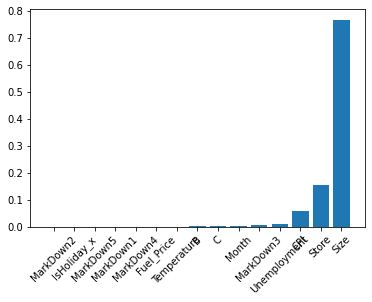

In [ ]:
plt.bar(pd.DataFrame(fi).iloc[:,1].values,  pd.DataFrame(fi).iloc[:,0].values)
plt.xticks(rotation= 45)

In [ ]:
predict = RF_regressor.predict(x_test)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 361 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 644 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    0.3s finished


In [ ]:
mean_absolute_percentage_error(y_test, predict)

11.3492193661739

In [ ]:
mean_absolute_error(y_test, predict)

110844.49079804441

In [ ]:
#CV Grid search

parameters = {'n_estimators':[1000], 'criterion':['mse'] , 'max_depth':(3,4,5,6,7,8,9) }

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
tree_RF = RandomForestRegressor()

In [ ]:
Reg_gcv = GridSearchCV(tree_RF,parameters, cv=5 , n_jobs=-1)

In [ ]:
Reg_gcv.fit(x_train, y_train,)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [ ]:
sorted(Reg_gcv.cv_results_.keys())

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'param_criterion',
 'param_max_depth',
 'param_n_estimators',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'split3_test_score',
 'split4_test_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score']

In [ ]:
Reg_gcv.best_params_

{'criterion': 'mse', 'max_depth': 9, 'n_estimators': 1000}

In [ ]:
y_hat1= Reg_gcv.predict(x_test)

In [ ]:
mean_absolute_percentage_error(y_test, y_hat1)

6.466536820257489

#### Tuned model


In [ ]:
{'criterion': 'mse', 'max_depth': 9, 'n_estimators': 1000}

In [41]:
RF_regressor_tuned = RandomForestRegressor(n_estimators=1000, criterion='mse', max_depth=9, n_jobs=-1, random_state=111, verbose=1, )
RF_regressor_tuned.fit(x_train,y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   13.6s finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=9, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=-1, oob_score=False,
                      random_state=111, verbose=1, warm_start=False)

In [43]:
predict = RF_regressor_tuned.predict(x_test)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    0.3s finished


In [44]:
mean_absolute_percentage_error(y_test, predict)

6.466016004754869

### Serialize the Model

In [47]:
import pickle 
pickle.dump(RF_regressor_tuned, open('/content/drive/MyDrive/Untitled Folder/regressor.pkl', 'wb')  )

In [48]:
model1 = pickle.load(open('/content/drive/MyDrive/Untitled Folder/regressor.pkl', 'rb'))

In [51]:
model1

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=9, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=-1, oob_score=False,
                      random_state=111, verbose=1, warm_start=False)